# Statsmodels Code Utils

This notebook includes different code utils for Statsmodels in Time Series.

In [17]:
# Import Standard Libraries
import pandas as pd
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [2]:
# Read data
macrodata_dataset = pd.read_csv('./../../data/raw/macrodata.csv', index_col=0, parse_dates=True)
passengers_dataset = pd.read_csv('./../../data/raw/airline_passengers.csv', index_col=0, parse_dates=True)

# Operations

## Hodrick-Prescott Filter

It is used to extract the trend and cyclic components from a time series.

<Axes: >

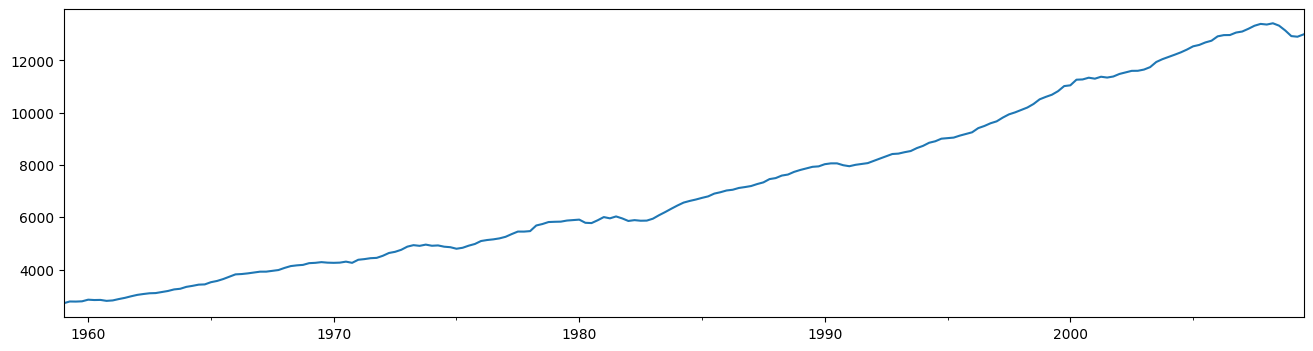

In [3]:
# Let's see the data
macrodata_dataset['realgdp'].plot(figsize=(16, 4))

In [4]:
# Use HP filter to separate trand component from cyclic one
gdp_cyclic, gdp_trend = hpfilter(macrodata_dataset['realgdp'], lamb=1600)

In [5]:
# Add gdp_trend back to dataframe
macrodata_dataset['gdp_trend'] = gdp_trend

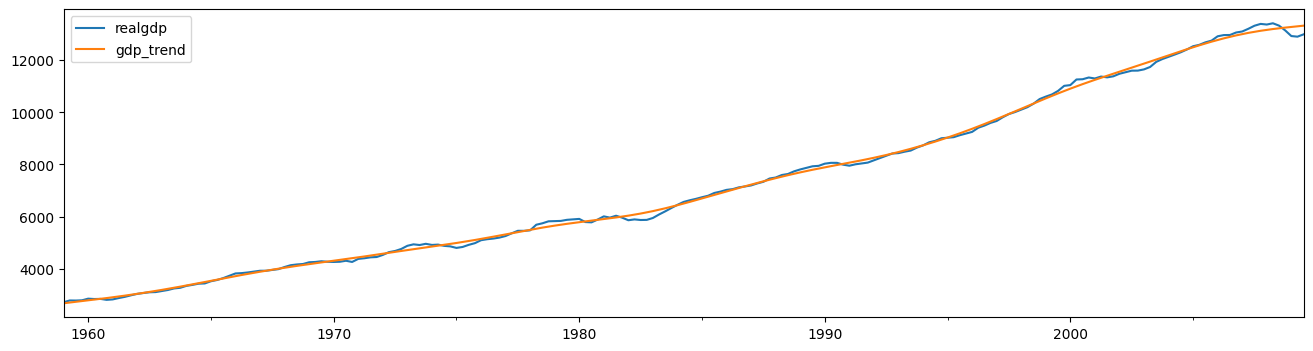

In [6]:
# Plot gdp_trend vs realgdp
_ = macrodata_dataset[['realgdp', 'gdp_trend']].plot(figsize=(16, 4))

In [7]:
macrodata_dataset.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,gdp_trend
1959-03-31,1959,1,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00,2670.837085
1959-06-30,1959,2,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74,2698.712468
1959-09-30,1959,3,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09,2726.612545
1959-12-31,1959,4,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06,2754.612067
1960-03-31,1960,1,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19,2782.816333


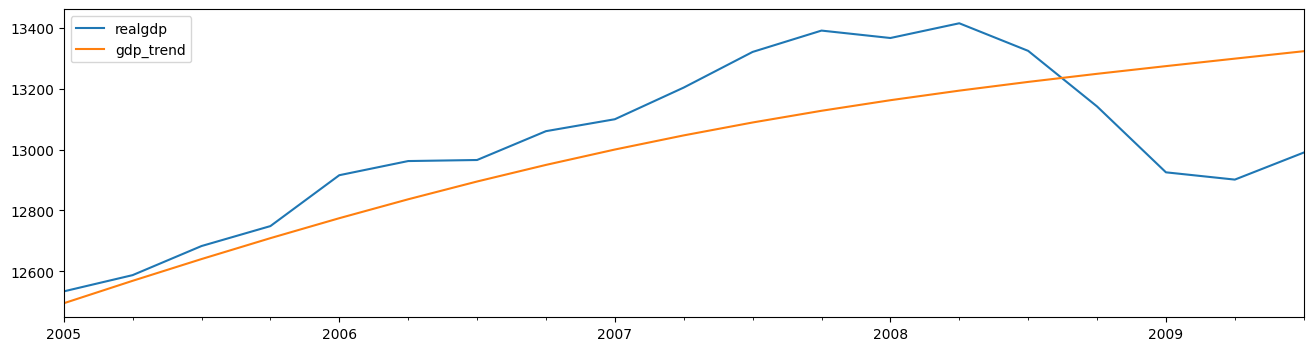

In [8]:
# Focus on just before the 2008 economic crisis
_ = macrodata_dataset[['realgdp', 'gdp_trend']].loc['2005-01-01':, :].plot(figsize=(16, 4))

## ETS Decomposition

It is used to extract the following components from a time series: trend, seasonality and error.

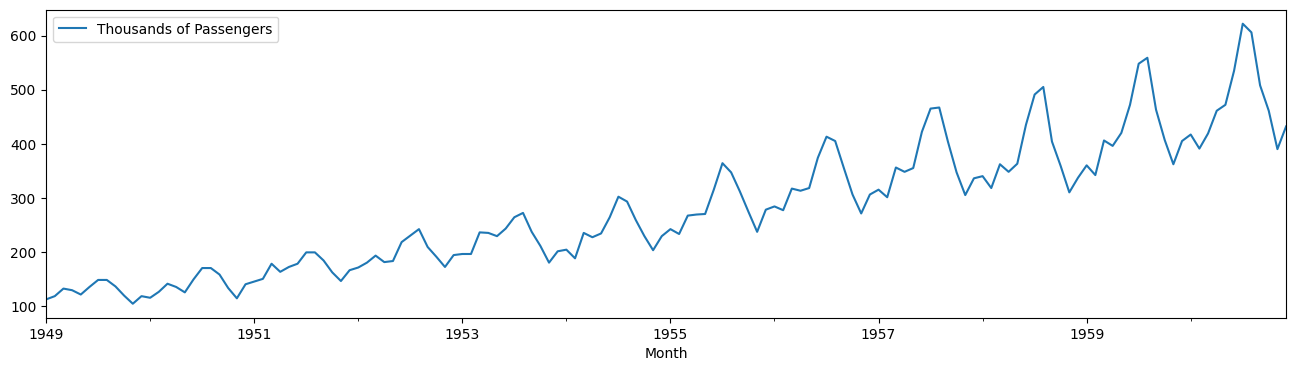

In [9]:
# Let's look at the data
_ = passengers_dataset.plot(figsize=(16, 4))

In [10]:
# Extract the components from the time series
passengers_dataset_components = seasonal_decompose(passengers_dataset['Thousands of Passengers'], 
                                                   model='multiplicative')

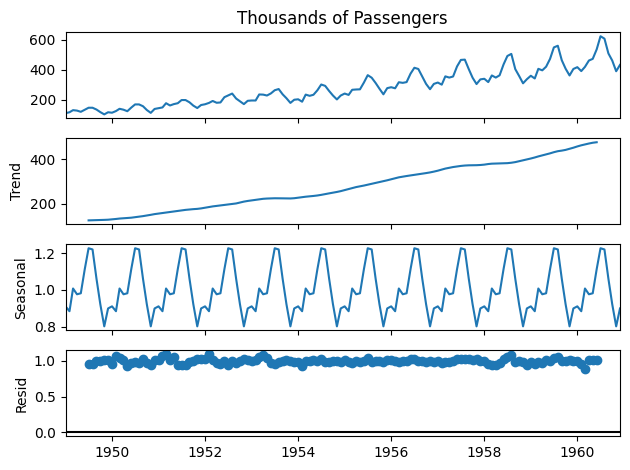

In [11]:
# NOTE: First plot is the time series itself
_ = passengers_dataset_components.plot()

# Modeling

## EWMA

The Exponentially Weighted Moving Average models a time series by giving more importance to the latest data points.

In [12]:
# Compute the EWMA
passengers_dataset['EWM-12'] = passengers_dataset['Thousands of Passengers'].ewm(span=12).mean()

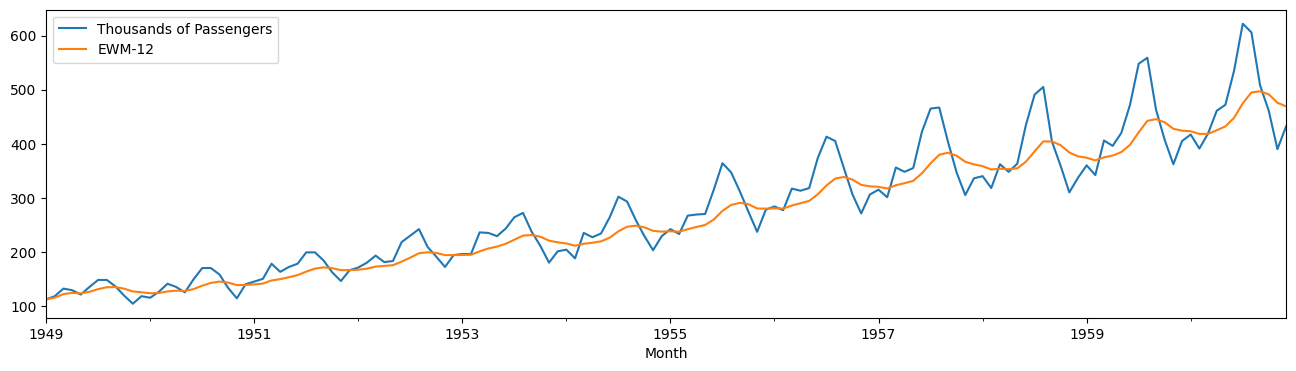

In [13]:
# Plot Time Series vs EWMA
_ = passengers_dataset[['Thousands of Passengers', 'EWM-12']].plot(figsize=(16, 4))

## Holt-Winters Modeling

In [15]:
# We need to check for the 'freq' of the observations
passengers_dataset.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [16]:
# Set the index frequency to 'Monthly Start'
passengers_dataset.index.freq = 'MS'

### Simple Exponential Smoothing

It is the same implementation has EWMA.

In [18]:
# Define model parameters
span = 12 # Dataset has yearly cycles
alpha = 2/(span + 1) # Standard formula for 'alpha' smoothing parameter

In [29]:
# Define the model
ses_model = SimpleExpSmoothing(passengers_dataset['Thousands of Passengers'])

# Fit the model
ses_model_fitted = ses_model.fit(smoothing_level=alpha, 
                                 optimized=False)

# Save the data
passengers_dataset['SES12'] = ses_model_fitted.fittedvalues.shift(-1)

In [30]:
# Compare results from EMWA to SES
print('SES Values:')
print(passengers_dataset['SES12'].head(3))

print('EMWA Values:')
print(passengers_dataset['EWM-12'].head(3))

SES Values:
Month
1949-01-01    112.000000
1949-02-01    112.923077
1949-03-01    115.857988
Freq: MS, Name: SES12, dtype: float64
EMWA Values:
Month
1949-01-01    112.000000
1949-02-01    115.250000
1949-03-01    121.787529
Freq: MS, Name: EWM-12, dtype: float64
